# Understanding and writing algorithms

`cfsPOPCON` is a library for running many simple interdependent calculations which have physically-meaningful inputs and outputs.

Although the example cases run through a pre-defined set of calculations, we wanted to allow users to change the order of the calculations, switch calculations on and off, and let users decide whether they want variables to be calculated or set as inputs.

To make this easier to do, we developed the `Algorithm` class. This has a fairly complicated implementation (see `cfspopcon/algorithm_class.py`), but it is straightforward to use.

In this notebook, we'll discuss what the `Algorithm` class is doing, and how to implement your own algorithms.

In [1]:
%reload_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import cfspopcon
from cfspopcon.unit_handling import Quantity, ureg

# Change to the top-level directory. Required to find radas_dir in its default location.
%cd {Path(cfspopcon.__file__).parents[1]}
# As a sanity check, print out the current working directory
print(f"Running in {Path('').absolute()}")

/Users/tbody/Projects/cfspopcon
Running in /Users/tbody/Projects/cfspopcon


## What does an algorithm look like?

To implement an algorithm, you need to first write a function such as the one below. Here, there are a few things to consider.

1. The function name sets the algorithm name, which must be unique. To find all of the algorithms which have been defined, you can run `poetry run popcon_algorithms` at the command-line. This will make a file called `popcon_algorithms.yaml` which lists the inputs and outputs of all algorithms.
2. The doc-string needs to be filled out with a one-line description, and a listing of all of the `Args` and `Returns` linking to an entry in `cfspopcon/variables.yaml`. The variables in cfspopcon are unit-aware, but it's still nice to remind a user of what the units are. You can add an extended description between the one-line description and the `Args/Returns` if you'd like. If you're adding a new variable, run `poetry run pre-commit run check_variables --all-files` to get a mostly-complete entry in `variables.yaml`.
3. Input and return variables should have names matching entries in the physics glossary. If you want to add a new variable, you can extend the glossary.
4. Input and return variables should have a type annotation. We often use `Unitfull`, which is a shorthand for `Union[Quantity, xr.DataArray]`.


In [2]:
from cfspopcon.algorithm_class import Algorithm, CompositeAlgorithm
from cfspopcon.unit_handling import Unitfull

def calc_plasma_volume_v2(major_radius: Unitfull, inverse_aspect_ratio: Unitfull, areal_elongation: Unitfull) -> Unitfull:
    """Calculate the plasma volume inside an up-down symmetrical last-closed-flux-surface.

    Geometric formulas for system codes including the effect of negative triangularity :cite: `sauter`
    NOTE: delta=1.0 is assumed since this was found to give a closer match to 2D equilibria from FreeGS.

    Args:
        major_radius: [m] :term:`glossary link<major_radius>`
        inverse_aspect_ratio: [~] :term:`glossary link<inverse_aspect_ratio>`
        areal_elongation: [~] :term:`glossary link<areal_elongation>`

    Returns:
        :term:`plasma_volume` [m^3]
    """
    return (
        2.0
        * np.pi
        * major_radius**3.0
        * inverse_aspect_ratio**2.0
        * areal_elongation
        * (np.pi - (np.pi - 8.0 / 3.0) * inverse_aspect_ratio)
    )

There's nothing special about this function. You can pass in regular scalar arguments, using `pint.Quantity` arguments if units matter.

In [3]:
calc_plasma_volume_v2(
    major_radius         = 1.0 * ureg.m,
    inverse_aspect_ratio = 0.5 / 1.0,
    areal_elongation     = 1.5
)

<Quantity(6.842694303998302, 'meter ** 3')>

You can also pass in `xarray` arguments.

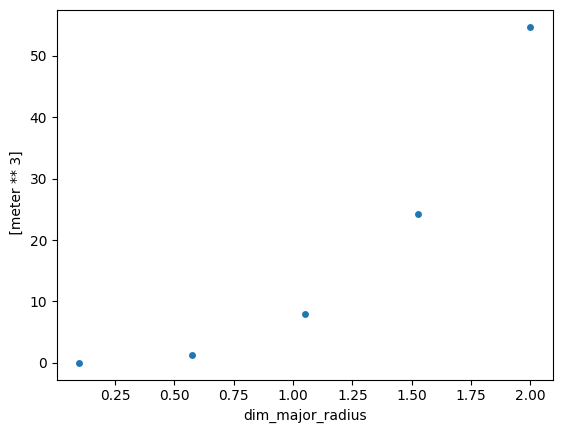

In [4]:
major_radius = np.linspace(0.1, 2.0, num=5)
major_radius = xr.DataArray(major_radius * ureg.m, coords=dict(dim_major_radius=major_radius))

plt.figure()
calc_plasma_volume_v2(
    major_radius         = major_radius,
    inverse_aspect_ratio = 0.5 / 1.0,
    areal_elongation     = 1.5
).plot.scatter()

## Let's turn this into an Algorithm

To turn this into an `Algorithm`, we just need to use the `register_algorithm` decorator. This doesn't change the function at all: it still behaves exactly like it did before.

*N.b. if you call this cell twice, it will fail the second time since Algorithms must have unique names*

In [5]:
@Algorithm.register_algorithm(return_keys=["plasma_volume"])
def calc_plasma_volume_v2(major_radius: Unitfull, inverse_aspect_ratio: Unitfull, areal_elongation: Unitfull) -> Unitfull:
    """Calculate the plasma volume inside an up-down symmetrical last-closed-flux-surface.

    Geometric formulas for system codes including the effect of negative triangularity :cite: `sauter`
    NOTE: delta=1.0 is assumed since this was found to give a closer match to 2D equilibria from FreeGS.

    Args:
        major_radius: [m] :term:`glossary link<major_radius>`
        inverse_aspect_ratio: [~] :term:`glossary link<inverse_aspect_ratio>`
        areal_elongation: [~] :term:`glossary link<areal_elongation>`

    Returns:
        :term:`plasma_volume` [m^3]
    """
    return (
        2.0
        * np.pi
        * major_radius**3.0
        * inverse_aspect_ratio**2.0
        * areal_elongation
        * (np.pi - (np.pi - 8.0 / 3.0) * inverse_aspect_ratio)
    )

print(calc_plasma_volume_v2(
    major_radius         = 1.0 * ureg.m,
    inverse_aspect_ratio = 0.5 / 1.0,
    areal_elongation     = 1.5
))

6.842694303998302 meter ** 3


So what did we just do? When we called `register_algorithm`, the function was added to the `instances` class attribute of the `Algorithm` class.

In [6]:
assert "calc_plasma_volume_v2" in Algorithm.instances

We can get the Algorithm corresponding to our function by using `get_algorithm` with the function name. This algorithm knows the names of all of its input and return arguments.

In [7]:
algorithm = Algorithm.get_algorithm("calc_plasma_volume_v2")

print(f"Algorithm '{algorithm._name}' has inputs {algorithm.input_keys} and returns {algorithm.return_keys}")

Algorithm 'calc_plasma_volume_v2' has inputs ['major_radius', 'inverse_aspect_ratio', 'areal_elongation'] and returns ['plasma_volume']


This Algorithm has a `run` method, which behaves a lot like calling the function itself. However, instead of returning a tuple of results, it returns an `xr.Dataset` of the results, where each return variable has a name.

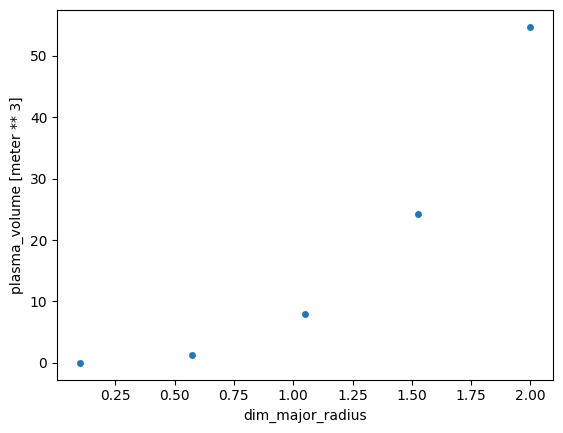

In [8]:
major_radius = np.linspace(0.1, 2.0, num=5)
major_radius = xr.DataArray(major_radius * ureg.m, coords=dict(dim_major_radius=major_radius))

ds = algorithm.run(
    major_radius         = major_radius,
    inverse_aspect_ratio = 0.5 / 1.0,
    areal_elongation     = 1.5
)

plt.figure()
ds["plasma_volume"].plot.scatter()

In addition to run, there is also an `update_dataset` method which runs on `xr.Dataset` inputs. The difference to `.run` is that the input dataset can contain things which aren't used by the algorithm. Since the algorithm knows the name of all of the input arguments, it can pick out the relevant parts of the input dataset.

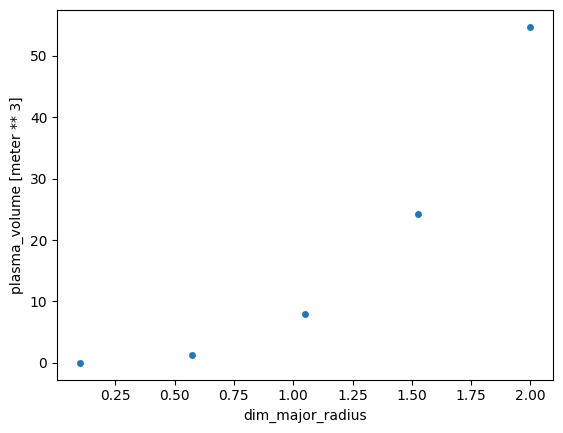

In [9]:
ds = xr.Dataset(data_vars=dict(
    major_radius          = major_radius,
    inverse_aspect_ratio  = 0.5 / 1.0,
    areal_elongation      = 1.5,
    why_did_i_define_this = xr.DataArray([1, 2, 3], dims="i_dont_know")
))

ds = algorithm.update_dataset(ds)

plt.figure()
ds["plasma_volume"].plot.scatter()

For a single function, this hasn't given us a huge advantage. Where Algorithms because very useful is when we have *many* algorithms which depend on each other. For instance, consider the following.

In [10]:
# If you have a single-line, simple function, you can use this shorthand.
# N.b. we've given it a long name because calc_inverse_aspect_ratio is already defined
Algorithm.from_single_function(
    func=lambda major_radius, minor_radius: minor_radius / major_radius,
    return_keys=["inverse_aspect_ratio"],
    name="calc_inverse_aspect_ratio_from_major_and_minor_radius",
)

Algorithm: calc_inverse_aspect_ratio_from_major_and_minor_radius

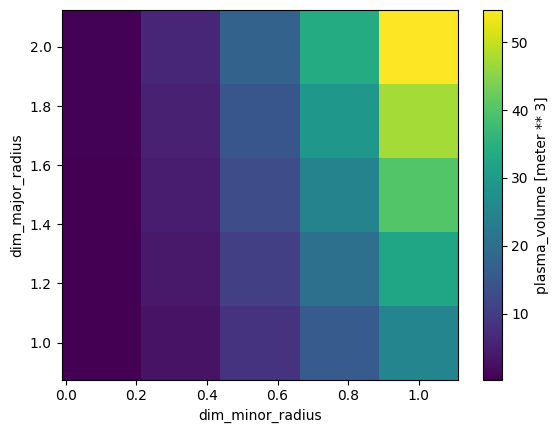

In [11]:
major_radius = np.linspace(1.0, 2.0, num=5)
major_radius = xr.DataArray(major_radius * ureg.m, coords=dict(dim_major_radius=major_radius))
minor_radius = np.linspace(0.1, 1.0, num=5)
minor_radius = xr.DataArray(minor_radius * ureg.m, coords=dict(dim_minor_radius=minor_radius))

ds = xr.Dataset(data_vars=dict(
    major_radius          = major_radius,
    minor_radius          = minor_radius,
    areal_elongation      = 1.5,
))

ds = Algorithm.get_algorithm("calc_inverse_aspect_ratio_from_major_and_minor_radius").update_dataset(ds)
ds = Algorithm.get_algorithm("calc_plasma_volume_v2").update_dataset(ds)
plt.figure()
ds["plasma_volume"].plot()

Here, we see that, using the `update_dataset` method, the Algorithm can figure out which outputs (i.e. `inverse_aspect_ratio`) from `calc_inverse_aspect_ratio_from_major_and_minor_radius` need to go into the inputs of `calc_plasma_volume_v2`.

This is fairly neat already. However, what if we always call the same algorithms in the same order?

Rather than having to write a wrapper algorithm, or remembering which inputs are calculated internally and which need to be defined as inputs, we can use the `CompositeAlgorithm` class by providing an ordered list of Algorithms.

In [12]:
algorithms = [
    "calc_inverse_aspect_ratio_from_major_and_minor_radius",
    "calc_plasma_volume_v2",
]
algorithms = [Algorithm.get_algorithm(alg) for alg in algorithms]

composite_algorithm = CompositeAlgorithm(algorithms, name="my_composite_algorithm", register=True)

print(f"CompositeAlgorithm '{composite_algorithm._name}' has inputs {composite_algorithm.input_keys} and returns {composite_algorithm.return_keys}")

CompositeAlgorithm 'my_composite_algorithm' has inputs ['major_radius', 'minor_radius', 'major_radius', 'areal_elongation'] and returns ['inverse_aspect_ratio', 'plasma_volume']


A second method is to use the `+` operator, although this is more for experimenting than to be used in finished code.

In [13]:
alg1 = Algorithm.get_algorithm("calc_inverse_aspect_ratio_from_major_and_minor_radius")
alg2 = Algorithm.get_algorithm("calc_plasma_volume_v2")

print(f"Anonymous CompositeAlgorithm has inputs {(alg1 + alg2).input_keys} and returns {(alg1 + alg2).return_keys}")

Anonymous CompositeAlgorithm has inputs ['major_radius', 'minor_radius', 'major_radius', 'areal_elongation'] and returns ['inverse_aspect_ratio', 'plasma_volume']


CompositeAlgorithms behave much the same as normal algorithms. If you give them a `name` and set `register=True`, they can be accessed using `Algorithm.get_algorithm`.

In [14]:
Algorithm.get_algorithm("my_composite_algorithm")

CompositeAlgorithm: my_composite_algorithm

They also have the same methods.

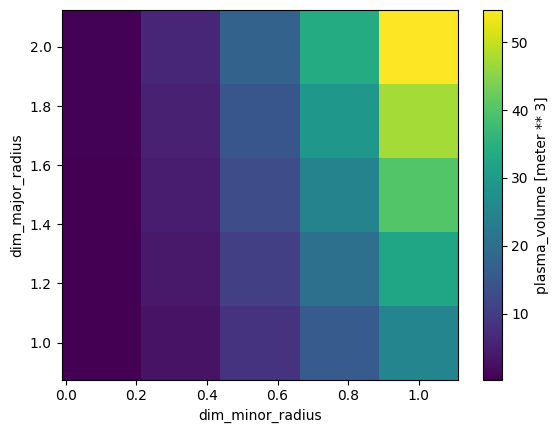

In [15]:
major_radius = np.linspace(1.0, 2.0, num=5)
major_radius = xr.DataArray(major_radius * ureg.m, coords=dict(dim_major_radius=major_radius))
minor_radius = np.linspace(0.1, 1.0, num=5)
minor_radius = xr.DataArray(minor_radius * ureg.m, coords=dict(dim_minor_radius=minor_radius))

ds = xr.Dataset(data_vars=dict(
    major_radius          = major_radius,
    minor_radius          = minor_radius,
    areal_elongation      = 1.5,
))

ds = Algorithm.get_algorithm("my_composite_algorithm").update_dataset(ds)
plt.figure()
ds["plasma_volume"].plot()

## Validating inputs

One helpful method, available to both `Algorithm` and `CompositeAlgorithm` objects, is `validate_inputs`. This checks whether there are any missing inputs (raises a `RuntimeEror`), whether all inputs are used (returns `True`) or if there are unused inputs (returns `False`).

In [16]:
ds = xr.Dataset(data_vars=dict(
    major_radius          = 1 * ureg.m,
    minor_radius          = 0.5 * ureg.m,
    areal_elongation      = 1.5,
))

Algorithm.get_algorithm("my_composite_algorithm").validate_inputs(ds)

True

In [17]:
ds = xr.Dataset(data_vars=dict(
    major_radius          = 1 * ureg.m,
    minor_radius          = 0.5 * ureg.m,
))

try:
    Algorithm.get_algorithm("my_composite_algorithm").validate_inputs(ds)
except RuntimeError as e:
    print(e)

Missing input parameters [areal_elongation].


In [18]:
ds = xr.Dataset(data_vars=dict(
    major_radius          = 1 * ureg.m,
    minor_radius          = 0.5 * ureg.m,
    areal_elongation      = 1.5,
    something_unused      = 1.5,
))

Algorithm.get_algorithm("my_composite_algorithm").validate_inputs(ds)

/var/folders/x2/fhfghwm566d83ws71kgzj86c0000gp/T/ipykernel_90530/772097659.py:8: UserWarning: Unused input parameters [something_unused].
  Algorithm.get_algorithm("my_composite_algorithm").validate_inputs(ds)


False

## Unit checking for inputs and outputs

Another advantage of using unique names for every input and output is that the `Algorithm` knows which units are expected for inputs and outputs.

For instance, if we tried to pass in `major_radius` in units of $m^2$, the `Algorithm` can tell us that something is going wrong.

In [19]:
ds = xr.Dataset(data_vars=dict(
    major_radius          = 1 * ureg.m**2,
    minor_radius          = 0.5 * ureg.m,
    areal_elongation      = 1.5,
    something_unused      = 1.5,
))

try:
    Algorithm.get_algorithm("my_composite_algorithm").update_dataset(ds)
except ValueError as e:
    print(e)

Cannot convert variables:
    incompatible units for variable None: Cannot convert from '1 / meter' (1 / [length]) to 'dimensionless' (dimensionless)


This can also help us catch if we've made an error in the formula itself, since the outputs also have known units.

In [20]:
from cfspopcon.unit_handling import DimensionalityError

@Algorithm.register_algorithm(return_keys=["plasma_volume"])
def calc_plasma_volume_v_wrong(major_radius: Unitfull, inverse_aspect_ratio: Unitfull, areal_elongation: Unitfull) -> Unitfull:
    """An intentionally broken plasma volume calculation.

    Args:
        major_radius: [m] :term:`glossary link<major_radius>`
        inverse_aspect_ratio: [~] :term:`glossary link<inverse_aspect_ratio>`
        areal_elongation: [~] :term:`glossary link<areal_elongation>`

    Returns:
        :term:`plasma_volume` [m^3]
    """
    return major_radius**4.0

try:
    Algorithm.get_algorithm("calc_plasma_volume_v_wrong").run(
        major_radius         = 1.0 * ureg.m,
        inverse_aspect_ratio = 0.5 / 1.0,
        areal_elongation     = 1.5
    )
except DimensionalityError as e:
    print(e)

Cannot convert from 'meter ** 4' ([length] ** 4) to 'meter ** 3' ([length] ** 3)


How is it doing this? For every variable passed in to or out of an Algorithm, there must be a corresponding entry in the `cfspopcon/variables.yaml` file. Then, to work out what units `plasma_volume` needs to have, the code basically does the following.

In [21]:
import yaml
from importlib.resources import as_file, files

with as_file(files("cfspopcon").joinpath("variables.yaml")) as filepath:
    with open(filepath) as f:
        variables_dictionary = yaml.safe_load(f)

print(variables_dictionary["plasma_volume"]["default_units"])

meter ** 3


## Making this work with input files

If you want to use the command-line-interface and add your algorithms in the `input.yaml` file, you need to make sure your `Algorithm` or `CompositeAlgorithm` is **imported in `cfspopcon/__init__.py`**. In practice, this means that any time you add a new submodule (folder) in `cfspopcon.formulas`, you need to add that submodule to `cfspopcon/formulas/__init__.py` and make sure that your algorithm is imported in `cfspopcon/formulas/your_new_folder/__init__.py`.

Then, it is worth understanding how these files are interpreted. The `algorithms` block is interpreted as a list of `Algorithm` names, which is used to build a big `CompositeAlgorithm` of everything that you've asked for.

This `CompositeAlgorithm` knows which inputs are defined in the calculation, and anything else needs to be given as an input. The `input.yaml` file only takes in scalar and array values, so you need to check `variables.yaml` to see what default units will be associated with a given input.

This all happens in `cfspopcon.read_case`.

In [22]:
input_parameters, algorithm, points, plots  = cfspopcon.read_case("example_cases/SPARC_PRD")

The `algorithm` object returned is a `CompositeAlgorithm`.

In [23]:
assert isinstance(algorithm, CompositeAlgorithm)

This `CompositeAlgorithm` is composed of several other algorithms, which you can see in the `algorithms` attribute.

In [24]:
algorithm.algorithms

[Algorithm: read_atomic_data,
 Algorithm: set_up_impurity_concentration_array,
 Algorithm: calc_separatrix_elongation_from_areal_elongation,
 Algorithm: calc_separatrix_triangularity_from_triangularity95,
 Algorithm: calc_minor_radius_from_inverse_aspect_ratio,
 Algorithm: calc_vertical_minor_radius_from_elongation_and_minor_radius,
 Algorithm: calc_plasma_volume,
 Algorithm: calc_plasma_surface_area,
 Algorithm: calc_f_shaping_for_qstar,
 Algorithm: calc_q_star_from_plasma_current,
 Algorithm: calc_average_ion_mass,
 Algorithm: calc_average_ion_temp_from_temperature_ratio,
 Algorithm: calc_zeff_and_dilution_due_to_impurities,
 Algorithm: calc_plasma_stored_energy,
 Algorithm: read_confinement_scalings,
 Algorithm: solve_energy_confinement_scaling_for_input_power,
 Algorithm: calc_beta_toroidal,
 Algorithm: calc_beta_poloidal,
 Algorithm: calc_beta_total,
 Algorithm: calc_beta_normalized,
 Algorithm: calc_peaked_profiles,
 Algorithm: calc_intrinsic_radiated_power_from_core,
 Algorithm:

At this point, you should understand what is going on in the next two lines.

In [25]:
dataset = xr.Dataset(input_parameters)
dataset = algorithm.update_dataset(dataset)

The final step is to look at the results, just like in the `getting_started.ipynb` notebook.

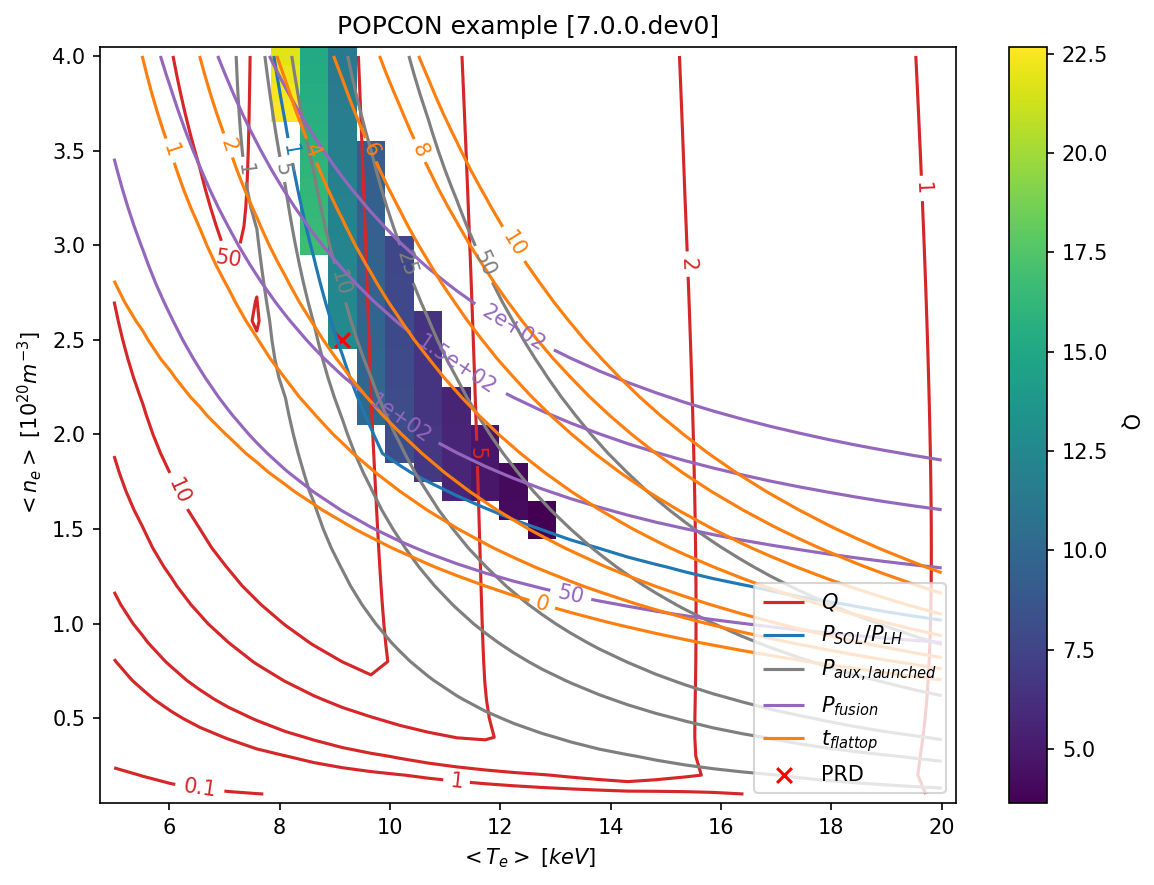

In [26]:
plot_style = cfspopcon.read_plot_style("example_cases/SPARC_PRD/plot_popcon.yaml")

cfspopcon.plotting.make_plot(
    dataset,
    plot_style,
    points=points,
    title="POPCON example",
    output_dir=None
)